In [1]:
from stable_baselines3 import DQN
import torch

In [94]:
model = DQN.load('../output_models/2021-06-18_16_57_43_15.zip')
model.load_replay_buffer("../output_models/2021-06-18_16_57_43_15_rb")

In [87]:
model = DQN.load('../best_model/best_model.zip')
# model.load_replay_buffer("../best_model/best_model_rb")

In [95]:
net = model.q_net
net.eval()

QNetwork(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (q_net): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [93]:
model.replay_buffer.observations.shape

(1000000, 1, 7)

In [96]:
X = model.replay_buffer.observations[0:5000]
X = torch.Tensor(X)

In [97]:
X.sum()

tensor(549.6610)

In [98]:
X.shape

torch.Size([5000, 1, 7])

In [99]:
from captum.attr import IntegratedGradients
import numpy as np

feature_names = np.array([        
    "vmAllocatedRatioHistory",
        "avgCPUUtilizationHistory",
        "p90CPUUtilizationHistory",
        "avgMemoryUtilizationHistory",
        "p90MemoryUtilizationHistory",
        "waitingJobsRatioGlobalHistory",
        "waitingJobsRatioRecentHistory"])

action_names = ['ACTION_NOTHING',
'ACTION_ADD_SMALL_VM',
'ACTION_REMOVE_SMALL_VM',
'ACTION_ADD_MEDIUM_VM',
'ACTION_REMOVE_MEDIUM_VM',
'ACTION_ADD_LARGE_VM',
'ACTION_REMOVE_LARGE_VM',]

In [100]:
x_axis_data = np.arange(X.shape[2])

ig = IntegratedGradients(net)

ig_attr_per_action = [ig.attribute(X, n_steps=50, target=target) for target in range(len(action_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

In [68]:

ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

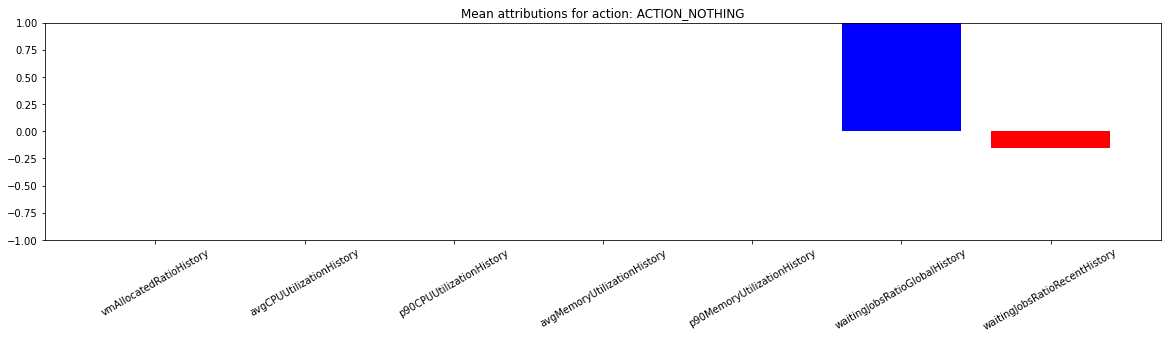

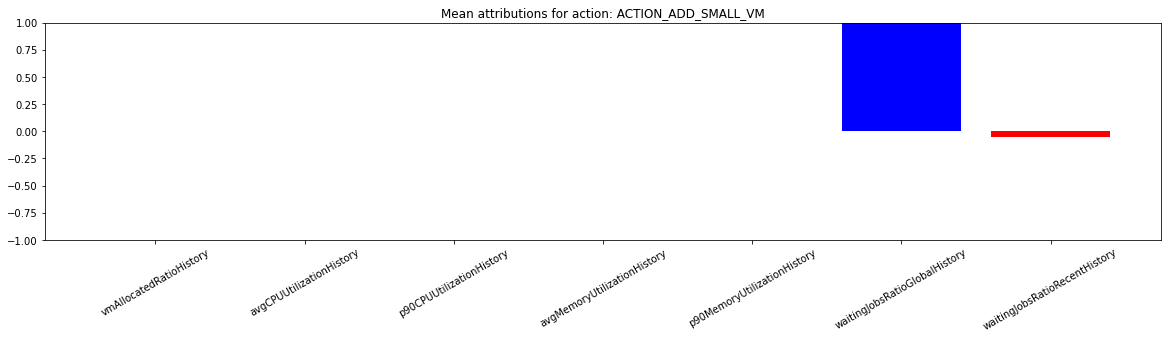

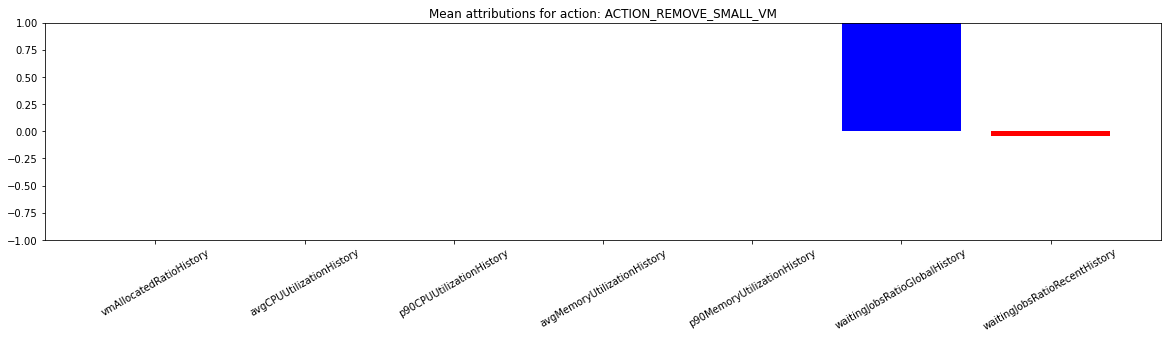

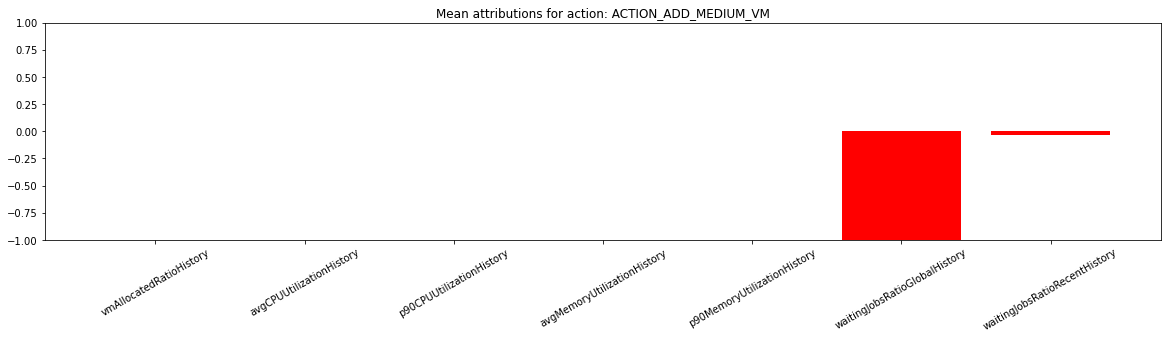

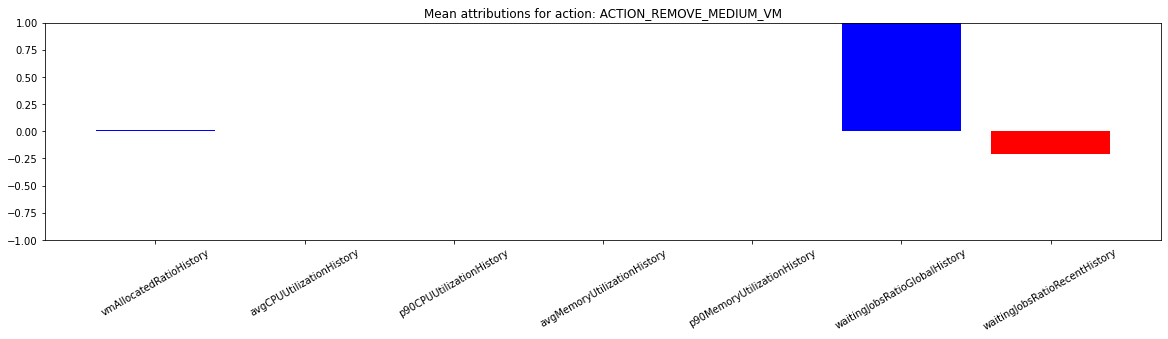

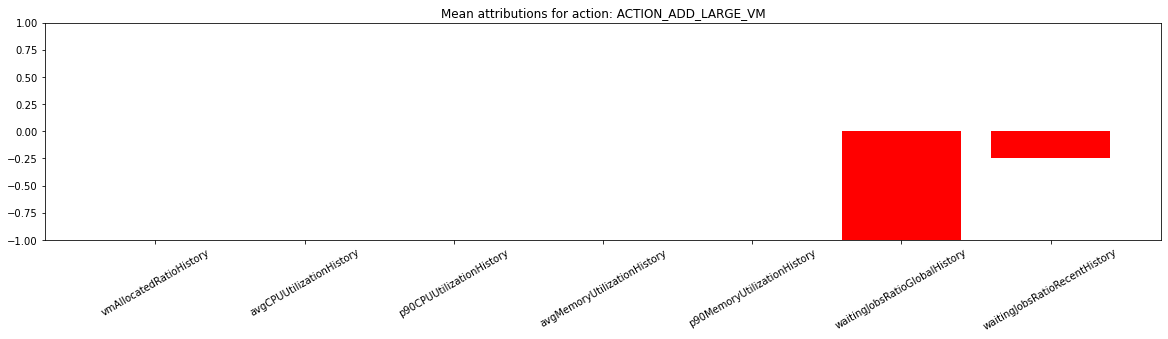

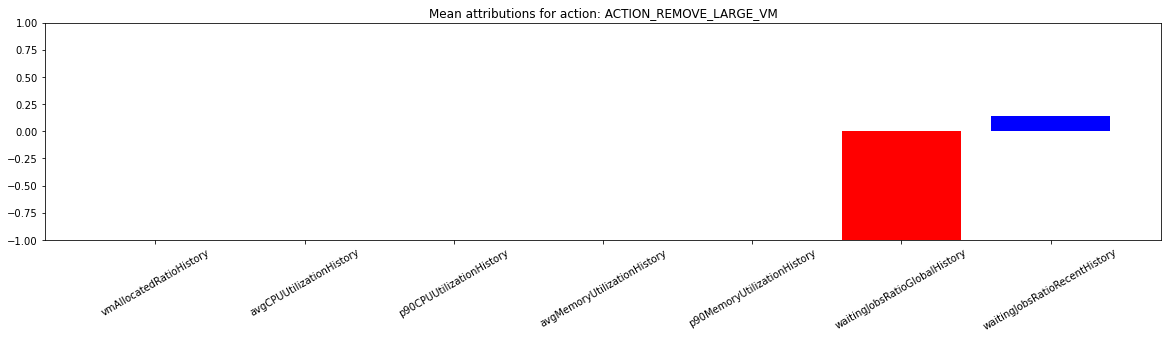

In [101]:
import matplotlib.pyplot as plt

for i, ig_attr in enumerate(ig_attr_test_norm_sum):
    plt.figure(figsize=(20, 4))
    plt.title(f'Mean attributions for action: {action_names[i]}')
    plt.xticks(x_axis_data, feature_names, rotation=30)
    plt.ylim([-1, 1])
    col = []
    for val in ig_attr[0]:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.bar(x_axis_data, ig_attr[0], color=col)

In [104]:
def render_env(img, feature_names):
    plt.figure(figsize=(20, 4))
    col = []
    for val in ig_attr[0]:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.xticks(range(7), feature_names, rotation=30)
    plt.bar(range(7), img, color=col)
#     plt.imshow(img)
#     plt.yticks(range(7), feature_names, size='large')
#     plt.colorbar()
#     plt.xlabel('Actions at each timestep')
#     plt.xticks(range(timesteps), df_a['actions'].values[:timesteps], rotation=60)
    plt.show()

In [105]:
def explain_action(idx, X, attributions, x_axis_data, feature_names, action_names, model, state=None):
    img = X[idx][0].numpy()


    q_values = model.q_net.forward(X[idx]).detach().numpy()
    action = np.argmax(q_values)
    
    print(f'Action: {action_names[action]}')
    
    render_env(img=img,
           feature_names=feature_names)
#     print(f'Q values')
#     print(f'   Left: {q_values[0][0]}')
#     print(f'   Right: {q_values[0][1]}')
#     print(f'State:')
#     for feature_value, feature in zip(X[idx][0].numpy(), feature_names):
#         print(f'   {feature}: {feature_value}')
        
    
    for i, ig_attr in enumerate(attributions):
        plt.figure(figsize=(20, 4))
        plt.title(f'Attributions for action: {action_names[i]}')
        plt.xticks(x_axis_data, feature_names, rotation=30)
#         plt.ylim([-1, 1])
        col = []
        ig_attr = ig_attr.numpy()[idx][0]
        for val in ig_attr:
            if val < 0.0:
                col.append('red')
            else:
                col.append('blue')
        plt.bar(x_axis_data, ig_attr, color=col)
    
#     plt.figure()
#     plt.title('Attributions when moving cart to the left')
#     plt.xticks(x_axis_data, feature_names)
# #     plt.ylim([-100, 100])
#     plt.bar(x_axis_data, attributions_left[idx][0])
    
#     plt.figure()
#     plt.title('Attributions when moving cart to the right')
#     plt.xticks(x_axis_data, feature_names)
    
# #     plt.ylim([-100, 100])
#     plt.bar(x_axis_data, attributions_right[idx][0])
    


Action: ACTION_REMOVE_MEDIUM_VM


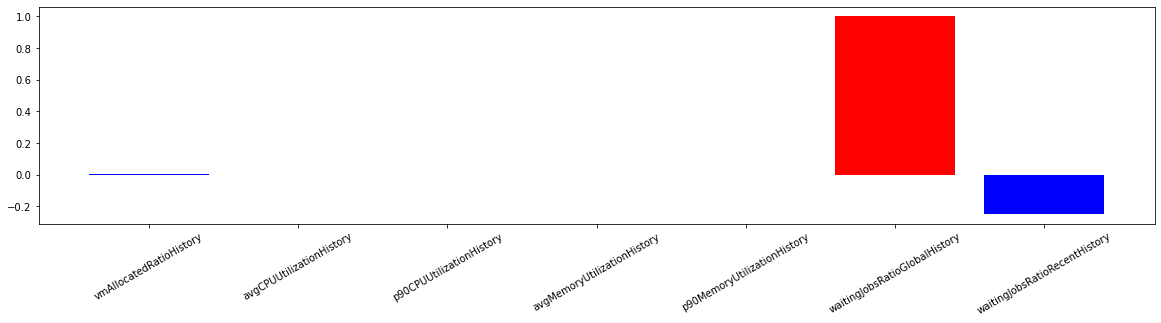

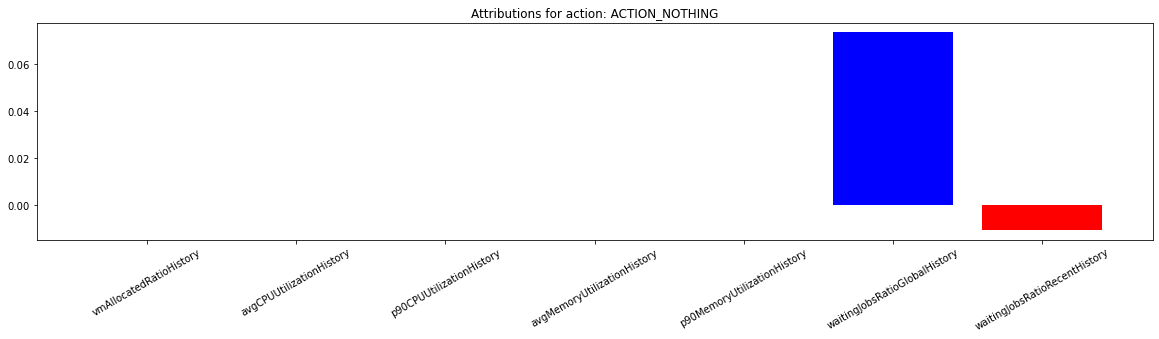

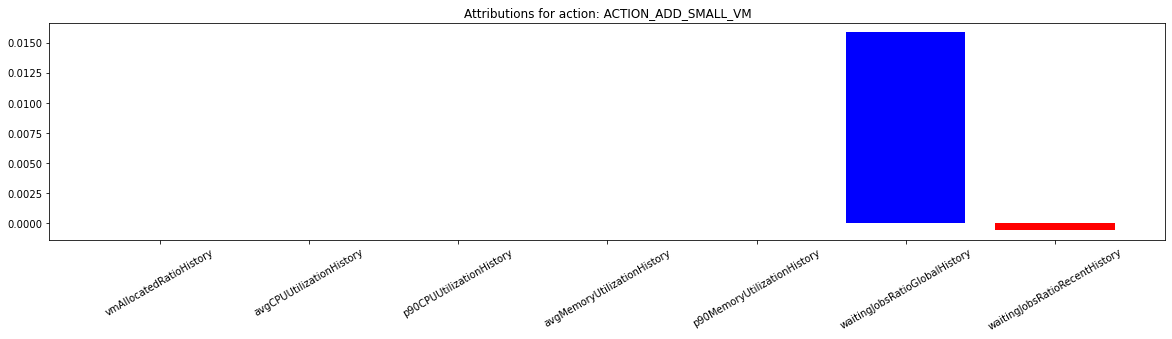

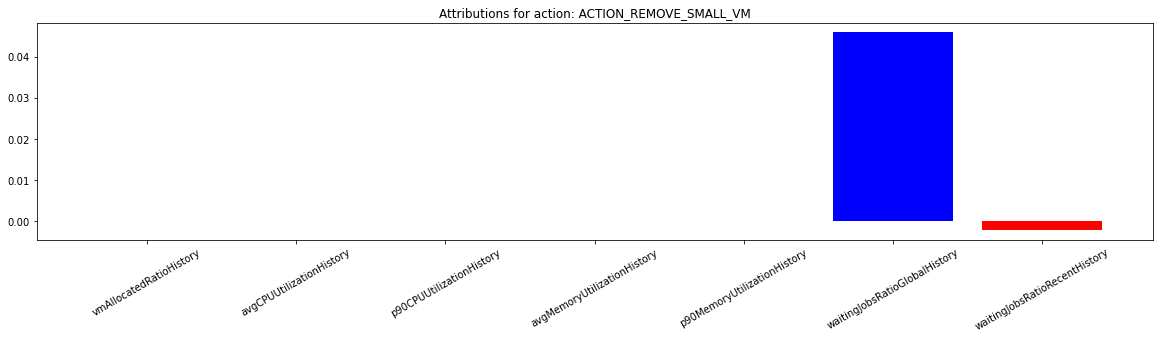

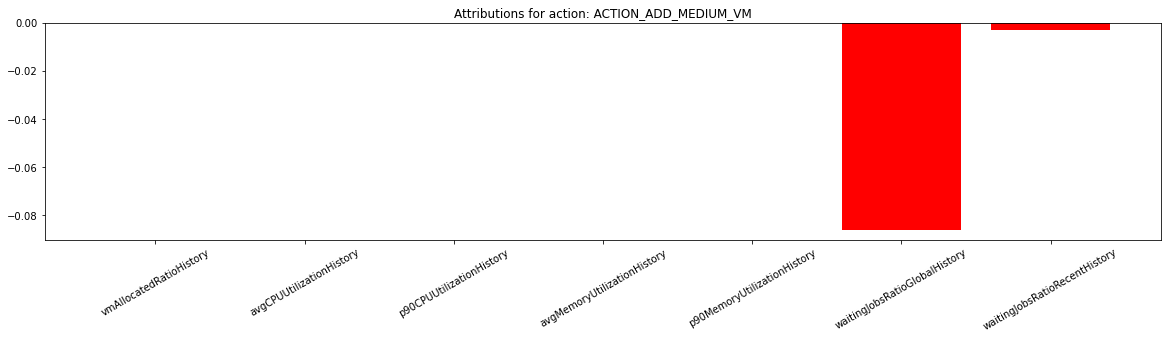

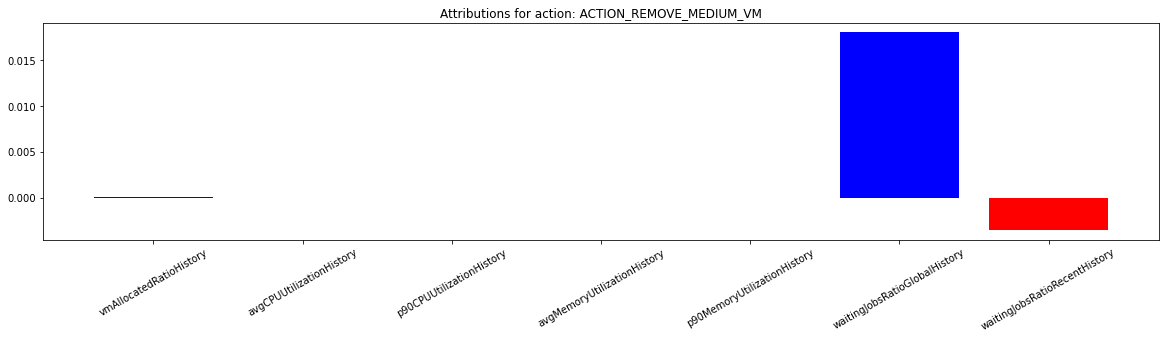

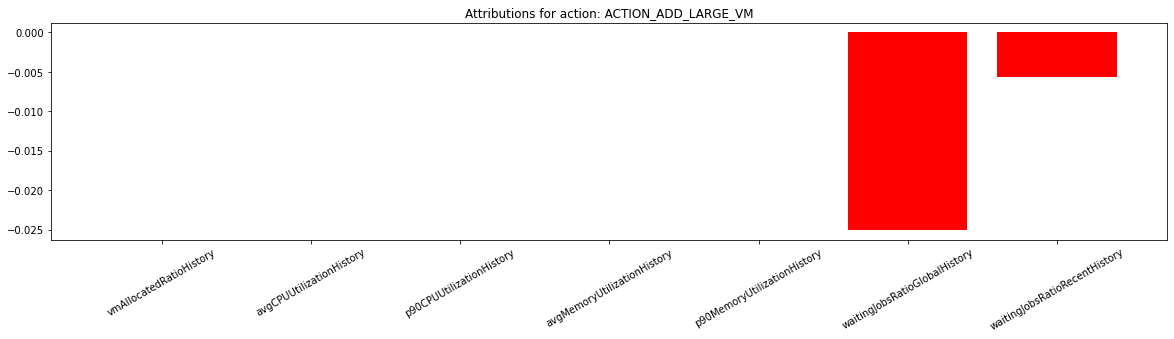

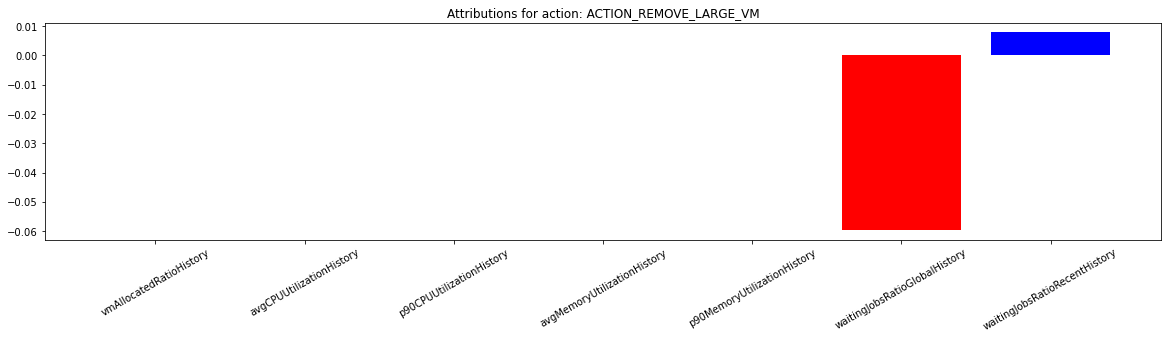

In [106]:
explain_action(idx=1000,
               X=X,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=model,
              )